In [1]:
# Astronomy 400B
# Homework 7
# Orbital Integration
# Marco Barragan

In [9]:
# Import modules
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as u
import astropy.constants as const
from ReadFile import Read
from CenterofMass import CenterOfMass
from GalaxyMass import ComponentMass
from IPython.display import Latex

In [3]:
class M33AnalyticOrbit:
    """
    Calculate the analytical oorbit of M33 around M31
    Input:
        file = the name you want to name your output file (ex. "filename.txt")
    Output:
        A text file with all of the information of the analytical orbit (t,x,y,z,vx,vy,vz)
    """
    def __init__(self,file):
        # Store Gravitational Constant (kpc^3/Msun/Gyr^2)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        # Store output file name
        self.filename = file
        
        # Create an instance for CenterOfMass class for M31
        M31COM = CenterOfMass("M31_000.txt", 2)
        
        # Store the position and velocity COM for 31
        M31_COMP = M31COM.COM_P(0.1)
        M31_COMV = M31COM.COM_V(M31_COMP[0], M31_COMP[1], M31_COMP[2])

        # Create an instance for CenterOfMass class for M33
        M33COM = CenterOfMass("M33_000.txt", 2)
        
        # Store the position and velocity COM for M33
        M33_COMP = M33COM.COM_P(0.1)
        M33_COMV = M33COM.COM_V(M33_COMP[0], M33_COMP[1], M33_COMP[2])
        
        # Store the difference in the COMP and COMV between M33 and M31
        self.r0 = M33_COMP.value - M31_COMP.value
        self.v0 = M33_COMV.value - M31_COMV.value
        
        # Store the mass values for each component of M31
        self.rDisk = 5        # kpc
        self.MDisk = ComponentMass('M31_000.txt',2) * 1e12
        
        self.rBulge = 1       # kpc
        self.MBulge = ComponentMass('M31_000.txt',3) * 1e12
        
        self.rHalo = 60       # kpc
        self.MHalo = ComponentMass('M31_000.txt',1) * 1e12
        
    
    # Deﬁne functions that will compute the gravitational acceleration 
    # vectors from 3 components of the M31 galaxy: Halo, Bulge and Disk
    
    # Bulge and Halo:
    #    Use gravitational acceleration according to a Hernquist Profile
    #    
    #    a = -GM/r(r_a+r)^2 * r_vector
    def HernquistAccel(self,M,r_a,r):
        """
        Input:
            M = the total halo or bulge mass (Msun)
            r_a = the corresponding scale length
            r = relative position vector
        Returns:
            a = acceleration vector
        """
        # Store the magnitude of position vector r
        rmag = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
        
        # Store constants (everything except vector)
        C = -self.G * M / (rmag * (r_a + rmag)**2)
        
        # Store acceleration vector
        a = C * r
        
        return a
    
    # Disk:
    #    Use gravitational potential defined by a Miyamoto-Nagai 1975 proﬁle
    # 
    #    phi = -GM /sqrt(R^2 + B^2)
    #    B = rdisk + sqrt(z^2 + zd^2)
    #    R = sqrt(x^2 + y^2)
    #    zdisk = rdisk / 2
    def MiyamotoNagaiAccel(self,M,rd,r):
        """
        Input:
            M = the total disk mass
            rd = the disk radius
            r = relative position vector
        Returns:
            a = acceleration vector
        """
        # Store constant values B, R, zd 
        zd = rd / 5
        R = np.sqrt(r[0]**2 + r[1]**2)
        B = rd + np.sqrt(r[2]**2 + zd**2)
        
        # Store part of equation as a constant
        C = -self.G * M /(R**2 + B**2)**1.5
        
        # Store the respective acceleration vector components
        ax = C*r[0]
        ay = C*r[1]
        az = C*r[2] * B / np.sqrt(r[2]**2 + zd**2)
        
        return np.array([ax,ay,az])
    
    
    # Find the total acceleration of M31 from all 3 components (disk, bulge, halo)
    def M31Accel(self,r):
        """
        Inputs:
            r = relative position vector
        Returns:
            total acceleration vector of M31 at radius r
        """
        # Store acceleration of M31 disk
        a_disk = self.MiyamotoNagaiAccel(self.MDisk,self.rDisk,r)
        
        # Store acceleration of M31 bulge
        a_bulge = self.HernquistAccel(self.MBulge,self.rBulge,r)
        
        # Store acceleration of M31 halo
        a_halo = self.HernquistAccel(self.MHalo,self.rHalo,r)
        
        # Add all of the accelerations together
        a = a_disk + a_halo + a_bulge
        
        return a
        
    
    # Build an integrator in order to solve for M33's respective orbit
    # Using a LeapFrog Method
    def LeapFrog(self,dt,r,v):
        """
        Input:
            dt = time intervals
            r = relative position vector
            v = relative velocity vector
        Returns:
            rnew = new integrated position vector
            vnew = new integrated velocity vector
        """
        # Predict the 3D position vector of M33’s center of mass (COM) at the middle of the timestep dt
        rhalf = r + v * (dt/2)
        
        # Store new velocity vector
        vnew = v + self.M31Accel(r) * dt
        
        # Store new position vector
        rnew = r + 0.5 * (vnew) * dt
        
        return rnew, vnew
    
    
    # Integrate the orbit by looping the LeapFrog function
    def OrbitIntegration(self,t0,dt,tmax):
        """
        Input:
            t0 = initial time
            dt = timestep
            tmax = final time
        Output:
            No return, but outputs a text file with values (t,x,y,z,vx,vy,vz) for each timestep
        """
        # Store initial time
        t = t0
        
        # Store initial position and velocity
        r = self.r0
        v = self.v0
        
        # initialize array that will store all of the values
        orbit = np.zeros([int(tmax/dt)+2,7])
        
        # Store into the first (initial) row of values
        orbit[0] = t0, *tuple(r), *tuple(v)
        
        # i = 0 has been stored already, so we will start with 1
        i = 1
        
        while(t<tmax):
            # Increase timestep
            t += dt
            
            # Store new integrated values for position and velocity
            rnew, vnew = self.LeapFrog(dt,r,v)
            
            # Store next row of values
            orbit[i] = t, *tuple(rnew), *tuple(vnew)
            
            # New position and velocity now become old 
            r = rnew
            v = vnew
            
            # Increase index
            i += 1
        
        # Save orbit as a text file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

In [4]:
# Initialize M33AnalyticalOrbit Class
M33AO = M33AnalyticOrbit("myfile.txt")

# Output file 
M33AO.OrbitIntegration(0,0.1,10);

In [5]:
# Store data from file
data = np.genfromtxt("myfile.txt",dtype=None,names=True)

# Store time
time = data['t'] 

# Store position
pos = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

# Store velocity
vel = np.sqrt(data['vx']**2 + data['vy']**2 + data['vz']**2)

In [6]:
# Store data from HW6
HW6_M31 = np.genfromtxt("Orbit_M31.txt",dtype=None,names=True)
HW6_M33 = np.genfromtxt("Orbit_M33.txt",dtype=None,names=True)

# Store time
HW6_time = HW6_M33['t'] * 15000 / 1e6 # same conversion used in HW6

# Store position
HW6_pos = np.sqrt((HW6_M33['x']-HW6_M31['x'])**2 + (HW6_M33['y']-HW6_M31['y'])**2 + (HW6_M33['z']-HW6_M31['z'])**2)

# Store velocity
HW6_vel = np.sqrt((HW6_M33['vx']-HW6_M31['vx'])**2 + (HW6_M33['vy']-HW6_M31['vy'])**2 + (HW6_M33['vz']-HW6_M31['vz'])**2)

# Plot the Orbit of M33 with Respect to M31


## Distance

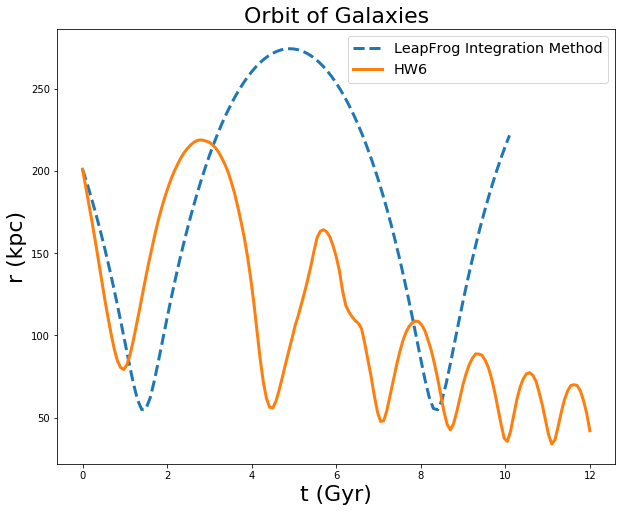

In [7]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.plot(time, pos, '--', linewidth=3, label='LeapFrog Integration Method')
plt.plot(HW6_time, HW6_pos, linewidth=3, label='HW6')

# Axes labels 
plt.title('Orbit of Galaxies',fontsize=22)
plt.xlabel('t (Gyr)',fontsize=22) 
plt.ylabel('r (kpc)', fontsize=22)

# Legend
plt.legend(loc='upper right',fontsize='x-large')

## Velocity

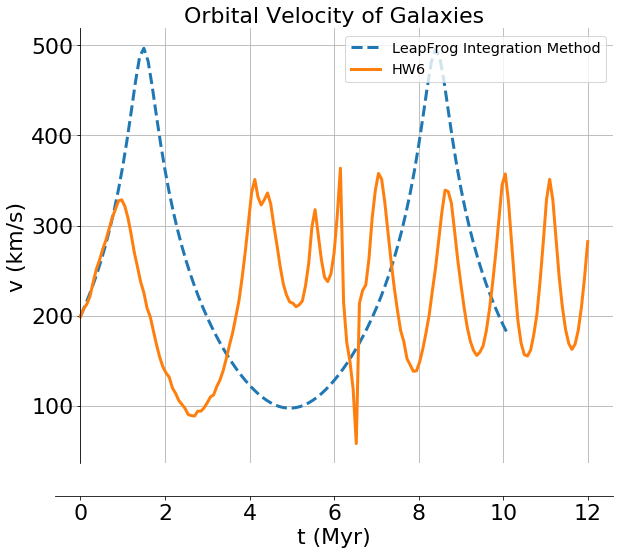

In [8]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.plot(time, vel, '--', linewidth=3, label='LeapFrog Integration Method')
plt.plot(HW6_time, HW6_vel, linewidth=3, label='HW6')

# Set a grid
ax.grid(True, which='both')

# Set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# Turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# Set the y-spine
ax.spines['bottom'].set_position('zero')

# Turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

# Axes labels 
plt.title('Orbital Velocity of Galaxies',fontsize=22)
plt.xlabel('t (Myr)',fontsize=22) 
plt.ylabel('v (km/s)', fontsize=22)

# Legend
plt.legend(loc='upper right',fontsize='x-large')

# Questions

## -How do the plots compare?

It seems that M33 is simply in an eliptical orbit with M31. As if M31 was a stationary point mass and M33 was just an orbiting mass.

## -What missing physics could make the diﬀerence?

Again, it seems that we have some elementary astronomy situation, where one object orbits another. This is simply not accurate. There are many more dynamics at play. One being that these objects are not point masses, and mas very well shed mass and be tidally preturbed. Another dynamic unrepresented is the motion of M31. The position labeled here does not account for the motion of M31 properly. M31 is not stationary, and neither is it in a fixed velocity. M31 is accelerating, and has other forces acting on it (MW). In general, that is what is missing: the proper representation of forces for the many objects that compose these massive galaxies.

## -The MW is missing in these calculations. How might you include its eﬀects?

Speaking of M31's motion, the MW is not used here. In particular we use M31 as the point mass that point mass M33 orbits around. We simply need to make another point mass (MW) that affects the acceleration of M31 (in M31Accel). The issue is that this would not be the only acceleration at play when using theLeapFrog function. We now need to include the acceleration of the MW. 